In [46]:
from fastai.vision.all import *
import csv
import glob
from collections import namedtuple
from pathlib import Path
import shap

import matplotlib.pyplot as pl
from shap.plots import colors

In [47]:
csv_path = 'B/B/train.csv'
b2_path = Path('B/B/data')
path = b2_path

In [48]:
b2_attr = 'id path'
b2_pred = 'oil wide hole hor_fine2 hor_tense barring borrisol hor_fine pe'
BRow = namedtuple('BRow', b2_attr + ' ' + b2_pred)
b2_feat = b2_pred.split(' ')

In [72]:
rows = []
path_to_tp = {}
train_images = []

with open(csv_path, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        row[1] = Path('B/B/data') / Path(row[1])
        if not row[1].exists(): continue
        row = BRow(*row)
        if row.oil != '1': continue
        pname = Path(row.path).name
        assert pname not in path_to_tp
        path_to_tp[pname] = row
        rows.append(row)
        train_images.append(Path(row.path))


In [50]:
def oil_label(f):
    return path_to_tp[f].oil

def wide_label(f):
    return path_to_tp[f].wide

def hole_label(f):
    return path_to_tp[f].hole

def hor_fine2_label(f):
    return path_to_tp[f].hor_fine2

def barring_label(f):
    return path_to_tp[f].barring

def borrisol_label(f):
    return path_to_tp[f].borrisol


def hor_tense_label(f):
    return path_to_tp[f].hor_tense

def hor_fine_label(f):
    return path_to_tp[f].hor_fine

def pe_label(f):
    return path_to_tp[f].pe

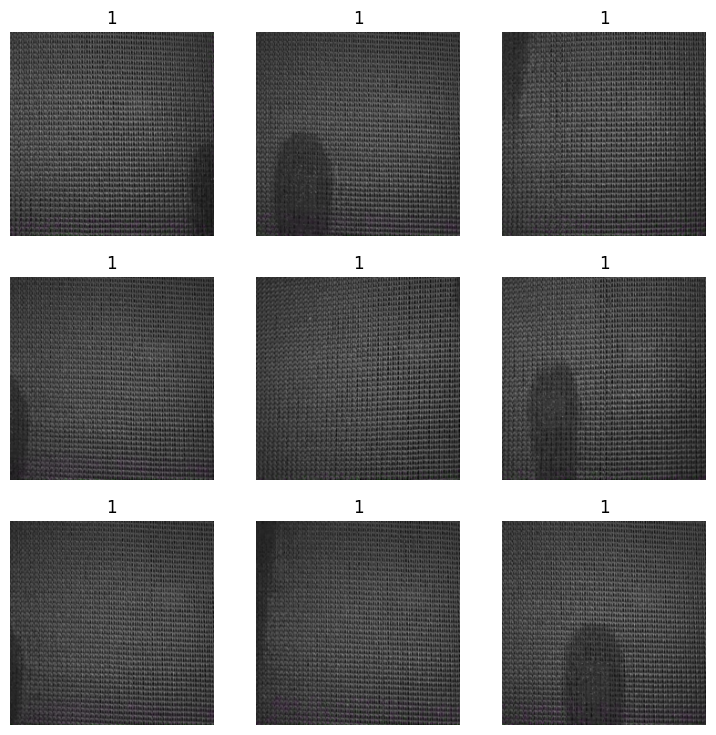

In [73]:
dls = ImageDataLoaders.from_name_func(path, train_images, oil_label, item_tfms=Resize(224),bs=16)
dls.show_batch()

In [59]:
train_tp = [
    ('oil'),
    ('wide'),
    ('hole'),
    ('hor_fine2'),
    ('hor_tense'),
    ('barring_fine'),
    ('borrisol_fine'),
    ('hor_fine'),
    ('pe'),
]

In [53]:
learn_dict = {}

for pred_type in train_tp:
    learn = load_learner(f'./green/models/{pred_type}')
    learn_dict[pred_type] = learn

In [74]:

# pull a sample of our data (128 images)
batch = dls.one_batch()

# specify how many images to use when creating the background distribution
num_samples = 8
explainer = shap.GradientExplainer(
    learn.model, batch[0][:num_samples]
)

# calculate shapely values
shap_values = explainer.shap_values(
    batch[0][num_samples:]
)

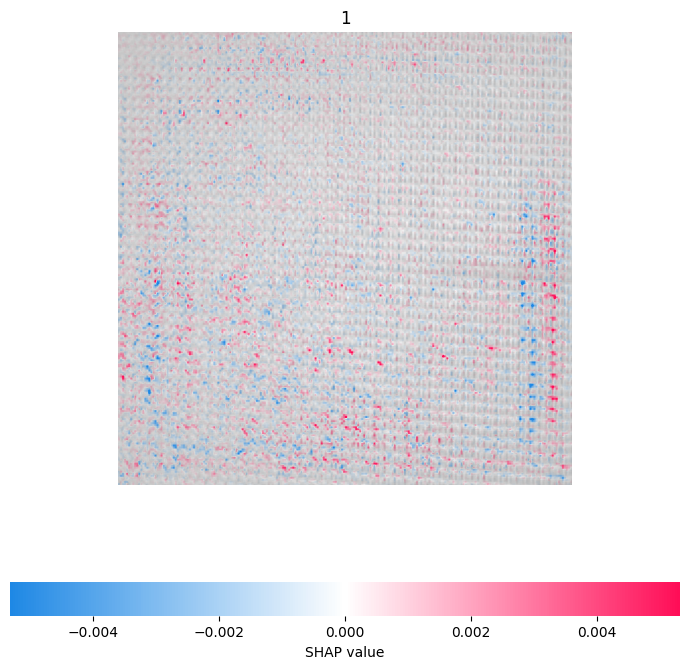

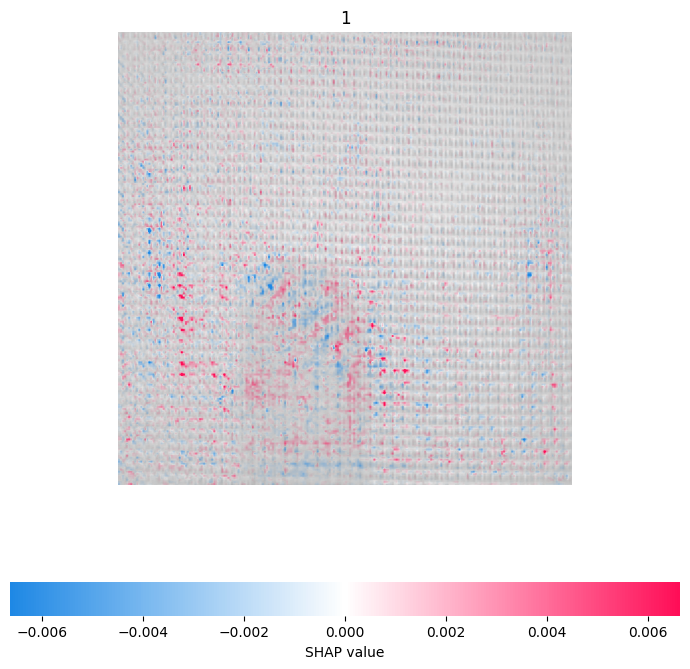

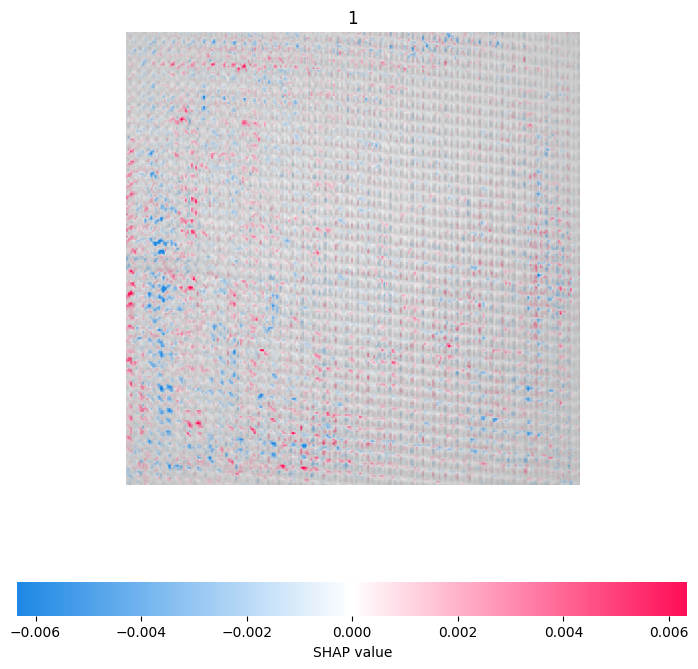

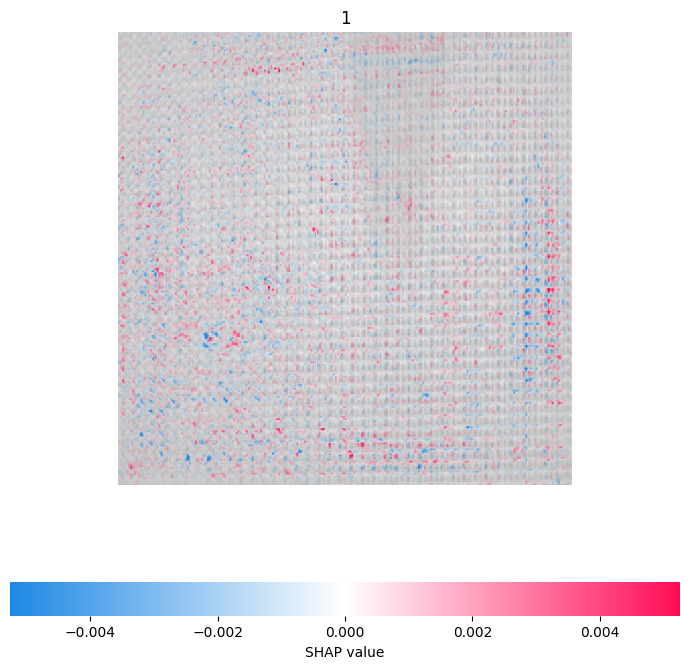

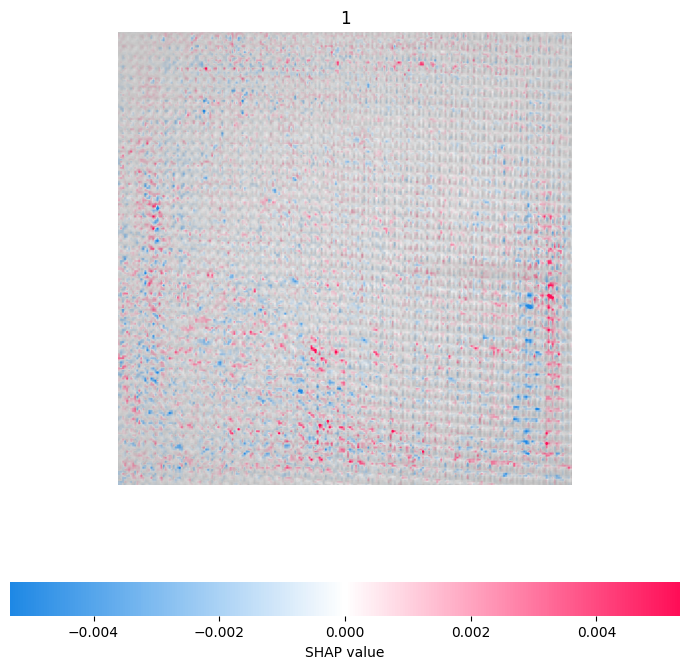

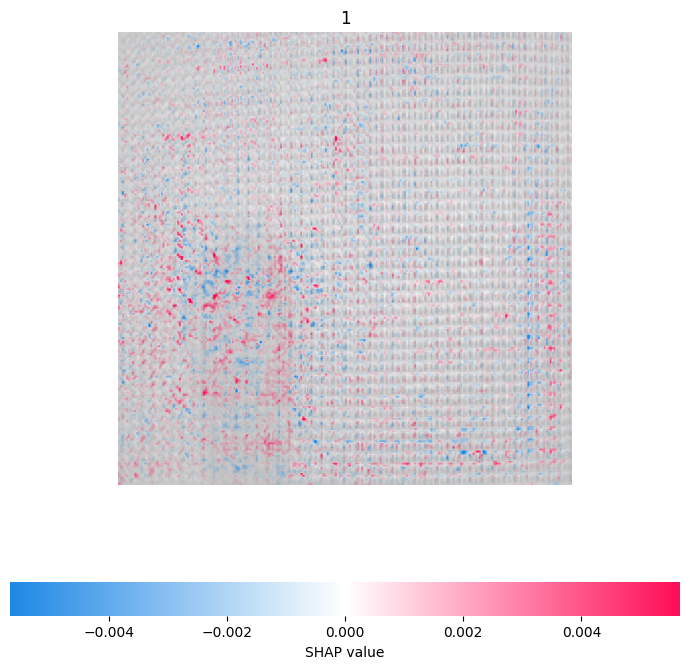

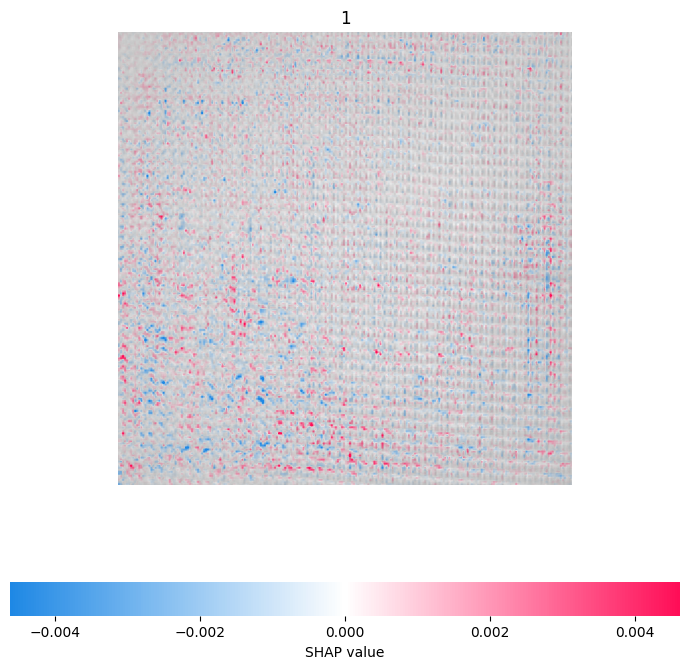

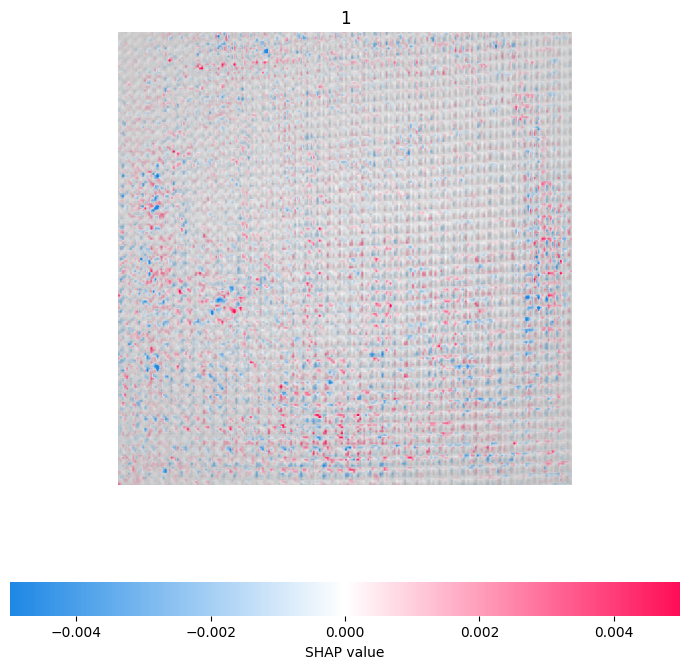

In [75]:
import matplotlib.pyplot as pl
from shap.plots import colors

for idx, x in enumerate(batch[0][num_samples:]):
    x = x.cpu() # move image to CPU
    label = dls.train.vocab[batch[1][num_samples:]][idx]
    sv_idx = list(dls.train.vocab).index(label)

    # plot our explanations
    fig, axes = pl.subplots(figsize=(7, 7))

    # make sure we have a 2D array for grayscale
    if len(x.shape) == 3 and x.shape[2] == 1:
        x = x.reshape(x.shape[:2])
    if x.max() > 1:
        x /= 255.

    # get a grayscale version of the image
    x_curr_gray = (
        0.2989 * x[0,:,:] +
        0.5870 * x[1,:,:] +
        0.1140 * x[2,:,:]
    )
    x_curr_disp = x

    abs_vals = np.stack(
        [np.abs(shap_values[sv_idx][idx].sum(0))], 0
    ).flatten()
    max_val = np.nanpercentile(abs_vals, 99.9)

    label_kwargs = {'fontsize': 12}
    axes.set_title(label, **label_kwargs)

    sv = shap_values[sv_idx][idx].sum(0)
    axes.imshow(
        x_curr_gray,
        cmap=pl.get_cmap('gray'),
        alpha=0.3,
        extent=(-1, sv.shape[1], sv.shape[0], -1)
    )
    im = axes.imshow(
        sv,
        cmap=colors.red_transparent_blue, 
        vmin=-max_val, 
        vmax=max_val
    )
    axes.axis('off')

    fig.tight_layout()

    cb = fig.colorbar(
        im, 
        ax=np.ravel(axes).tolist(),
        label="SHAP value",
        orientation="horizontal"
    )
    cb.outline.set_visible(False)
    pl.show()

In [56]:
instance_with_hole = 'B/B/data/4d9e728d-frame0-00-13.15.jpg'